<img src='../images/cbslogo.jpg' width="30%" align="left" />

# Support Vector Machine
## - Phase: Data Modelling - 

### Ziel
Prognose der Ausleihvorgänge insgesamt und pro Station für jeweils eine Stunde eines Tages mithilfe eines geeigneten Machine Learning Modells!

**Zielvariable:** Ausleihvorgänge

**Einflussvariablen:** Monat, Tag, Stunde, Wochentag, Wetter


Dieses Notebook verwendet die Dateien 
counts_tmp.pkl und counts_prepared.pkl. 

Durch dieses Notebook werden keine weiteren Dateien erzeugt.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn.svm import SVC
import warnings

In [2]:
DATA_PATH = '../data/'
DATA_FILE = 'counts_tmp.pkl'
FINAL_DATA_FILE = 'counts_prepared.pkl'

In [3]:
#df = pd.read_pickle(DATA_PATH+'counts_enriched.pkl')
df_trips = pd.read_pickle(DATA_PATH+FINAL_DATA_FILE)
df_trips_tmp = pd.read_pickle(DATA_PATH+DATA_FILE)

In [4]:
df_trips_tmp.head()

,date,Holiday,count_in,count_out,day_of_week,dewpoint,hour,humidity,precipitation,pressure,temperature,winddirection,windspeed,weekday,workingday,Season
0,2015-01-01,True,42,54,1,-14.0,0,29.0,0.0,1026.7,2.2,220.0,5.4,Thursday,0,Winter
1,2015-01-01,True,98,114,1,-12.3,1,36.0,0.0,1026.5,1.1,210.0,7.6,Thursday,0,Winter
2,2015-01-01,True,116,100,1,-11.0,2,40.0,0.0,1026.3,1.1,230.0,5.4,Thursday,0,Winter
3,2015-01-01,True,27,16,1,-11.8,3,39.0,0.0,1025.6,0.6,250.0,5.4,Thursday,0,Winter
4,2015-01-01,True,7,8,1,-11.2,4,41.0,0.0,1025.1,0.6,170.0,9.4,Thursday,0,Winter


# Vorbereitungen
## Korrelationsmatrix
Darstellung von Zusammenhängen, um ein erstes Bild von den Daten zu bekommen. 

C:\Users\tanja\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


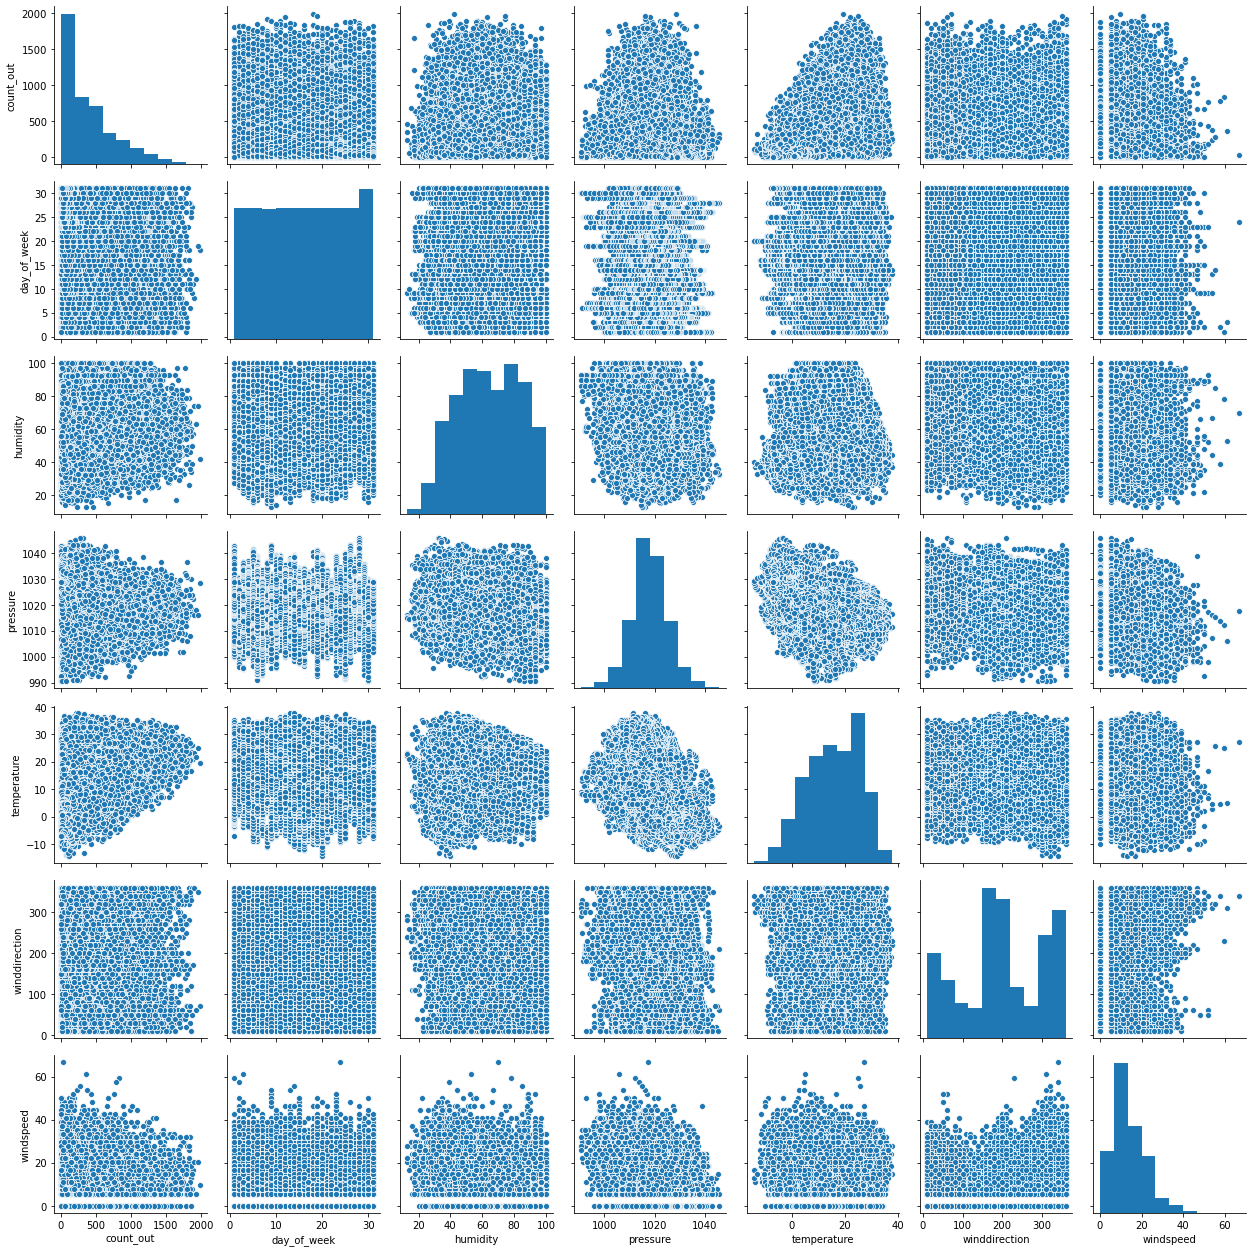

In [5]:
cols = ['count_out', 'day_of_week', 'humidity', 'pressure', 'temperature', 'winddirection', 'windspeed']
sns.pairplot(df_trips_tmp[cols], size=2.5)
plt.tight_layout()
plt.show()

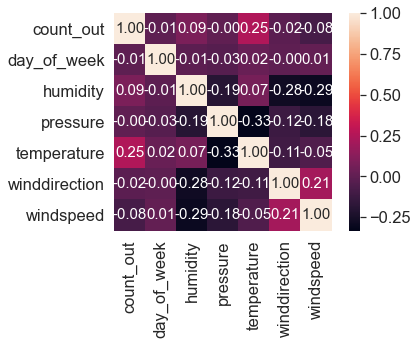

In [6]:
cm = np.corrcoef(df_trips_tmp[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(
    cm,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 15},
    yticklabels=cols,
    xticklabels=cols
)
plt.show()

* Kaum einzelne Zusammenhänge erkennbar.
* Lediglich "Temperatur" scheint noch am stärksten einen Einfluss zu haben

Überlegungen: 
* Bins für Ausleihen erstellen?
* Ausreißer mit RANSAC eliminieren?
* Sollen für das Modell alle Parameter beachtet werden, auch wenn diese scheinbar keinen Einfluss auf die Zielvariable besitzen?
* Wie kann man die Veränderung der Ausleihen über die Jahre berücksichtigen? Also einen Anstieg der Kunden? Falls es einen größeren Anstieg von einem Jahr zum anderen gab, werden die Daten für die Prognose verzerrt. Eventuell die Wachstumsrate pro Jahr ermitteln und die Ausleihen der zurückliegenden Jahre damit multiplizieren?

In [7]:
df_trips.head()

,count_in,count_out,day_of_week,dewpoint,humidity,precipitation,pressure,temperature,winddirection,windspeed,...,hour_19,hour_20,hour_21,hour_22,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,42,54,1,-14.0,29.0,0.0,1026.7,2.2,220.0,5.4,...,0,0,0,0,0,0,0,1,0,0
1,98,114,1,-12.3,36.0,0.0,1026.5,1.1,210.0,7.6,...,0,0,0,0,0,0,0,1,0,0
2,116,100,1,-11.0,40.0,0.0,1026.3,1.1,230.0,5.4,...,0,0,0,0,0,0,0,1,0,0
3,27,16,1,-11.8,39.0,0.0,1025.6,0.6,250.0,5.4,...,0,0,0,0,0,0,0,1,0,0
4,7,8,1,-11.2,41.0,0.0,1025.1,0.6,170.0,9.4,...,0,0,0,0,0,0,0,1,0,0


## Weiterführende Vorbereitung der Daten

### *Optional - Binning der Ausleihen
Momentan wird jede auf die Stunde aggregierte Ausleihe als eine Klasse betrachtet. 
Durch die Erstellung von Bins könnte man die Anzahl der Klassen verringern, wodurch der Algorithmus evtl genauer arbeiten kann und es geht nicht allzu viel Information verloren. 

In [8]:
# Anzahl der Klassen überprüfen
print(f"Anzahl verschiedener Ausleih-'Klassen': {len(df_trips['count_out'].unique())}")

Anzahl verschiedener Ausleih-'Klassen': 1668


In [9]:
no_bins=10
bin_lables = [x for x in range(0, no_bins)]

df_trips['count_out_qcut'] = pd.qcut(df_trips['count_out'], q=no_bins)
df_trips['count_out_qcut_lbl'] = pd.qcut(df_trips['count_out'], q=no_bins, labels=bin_lables)
df_trips['count_out_qcut'].value_counts()

(-0.001, 12.0]     2682
(399.0, 517.0]     2641
(43.0, 99.0]       2634
(961.9, 1988.0]    2624
(685.8, 961.9]     2623
(294.0, 399.0]     2614
(99.0, 185.0]      2614
(185.0, 294.0]     2613
(517.0, 685.8]     2602
(12.0, 43.0]       2585
Name: count_out_qcut, dtype: int64

# Konfiguration SVM
Hier wird die Support Vector Machine initial konfiguriert.

Erst werden generelle Funktionen definiert:

In [10]:
# Implementierung des RMSE
def rmsle(y_test, y_pred):
    rmsle = np.sqrt(mean_squared_log_error( y_test, y_pred ))
    #msle = metrics.mean_squared_log_error(y_test, y_pred)
    #rmse = math.sqrt(mse)
    return (rmsle)

In [11]:
def score_model(model):
    """ 
    Fits a model using the training set, predicts using the test set, and then calculates 
    and reports goodness of fit metrics.
    """
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    r2 = r2_score(y_test, yhat)
    me = rmsle(y_test, yhat)
    print("Results from {}: \nr2={:0.3f} \nRMSLE={:0.3f}".format(model, r2, me))
    accuracy = accuracy_score(y_test, yhat)*100
    print(f"Das trainierte Modell ist zu {accuracy}% zutreffend.")

Dann werden die Eingabedaten festgelegt:

In [18]:
# Eingabedaten
#X = df_trips[["day_of_week", "temperature"]]
X = df_trips.drop(['count_in', 'count_out', 'count_out_qcut', 'count_out_qcut_lbl'], axis=1)

# Zielvariable
y = df_trips["count_out_qcut_lbl"]

# Konfiguration SVM
model = svm.SVC()

### Train Test Split
Für die Aufteilung von Trainigs- und Testdaten wird ein Modul von Sklearn verwendet. Wir wollen 20% Testdaten haben.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

### SVM mit Default-Parametern

In [20]:
# SVM anwenden
# model.fit(X_train, y_train)
score_model(model)

Results from SVC(): 
r2=-0.896 
RMSLE=1.060
Das trainierte Modell ist zu 13.036020583190394% zutreffend.


Die Treffergenauigkeit des Modells ist mit der Initialkonfiguration nicht sehr hoch. 
Durch ein Tuning des Modells versuchen wir eine höhere Genauigkeit zu erreichen.

## Tuning
Nun wollen wir die Parameter der SVM anpassen, um eine höhere Genauigkeit zu erzielen.

### Soft Margin Klassifikation
Der Hyperparameter C kann verwendet werden, um Margin-Verletzungen (bei Außreißern) zu steuern. Ein hoher Wert von C führt dazu, dass der Klassifikator weniger Verletzungen der Margin zulässt, aber dafür einen schmaleren Margin in Kauf nimmt. 
Ein niedriger Wert für C macht den Margin breiter, aber dafür landen mehr Punkte innerhalb der Margin-Verletzung.

### Kernel-Trick
Der Kernel ist momentan auf eine radiale Basisfunktion (rbf) festgelegt, da die Daten nicht linear trennbar sind. Mögliche Kernel sind: 
- linear, poly, rbf, sigmoid, precomputed

## SVM Bewertung
Zur Bewertung des Modells stehen vordefinierte Module zur Verfügung.

In [27]:
model = svm.SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)

score_model(model)

Results from SVC(C=10.0, gamma=0.1, random_state=1): 
r2=-0.992 
RMSLE=1.168
Das trainierte Modell ist zu 15.627977892128836% zutreffend.


In [26]:
model = svm.SVC(kernel='rbf', random_state=1, gamma='scale', C=50)

score_model(model)

Results from SVC(C=50, random_state=1): 
r2=-1.042 
RMSLE=1.051
Das trainierte Modell ist zu 15.246807699637888% zutreffend.


### PCA
PCA kann verwendet werden, um Dimensionen zu reduzieren:

In [25]:
# for PCA we need to scale the data
scaler1 = StandardScaler()
scaler1.fit(X)
feature_scaled = scaler1.transform(X)

# Now apply PCA
pca1 = PCA(n_components = 6)
pca1.fit(feature_scaled)
feature_scaled_pca = pca1.transform(feature_scaled)
print("Shape of the scaled and 'PCA'ed features: ", np.shape(feature_scaled_pca))

Shape of the scaled and 'PCA'ed features:  (26232, 6)


### Pipeline
Nun bauen wir eine Pipeline, um die Skalierung, PCA und SVM mit unterschiedlichen Parametern zu testen.

(Hinweis: Pipeline läuft lokal nicht, da zu rechenintensiv. Daher wurde kein Ergebnis erzielt)

In [ ]:
# Pipeline
pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('SupVM', SVC(kernel='rbf'))]

check_params= {
    'pca__n_components': [4],
    'SupVM__C': [0.1, 0.5, 1, 10, 50],
    'SupVM__gamma': [0.005, 0.01, 0.05, 0.1, 1, 5]
}

pipeline = Pipeline(pipe_steps)

In [ ]:
# Execute Pipeline
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm

print("Start Fitting Training Data")
for cv in tqdm(range(4,6)):
    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
    create_grid.fit(X_train, y_train)
    print("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, y_test)))
    print("!!!!! Best-Fir parameters from Training Data !!!!!")
    print(create_grid.best_params_)
    
print("Out of the loop")